# Analyzing NYC High School Data

The SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each is worth 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic datasets. Below is a summary of the datasets used:

* SAT scores by school - SAT scores for each high school in New York City
* School attendance - Attendance information for each school in New York City
* Class size - Information on class size for each school
* AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* Graduation outcomes - The percentage of students who graduated and other outcome information
* Demographics - Demographic information for each school
* School survey - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test.

# Read in the Data

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("D:/Library/datasci/datasets/schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the Surveys

In [3]:
all_survey = pd.read_csv("D:/Library/datasci/datasets/schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("D:/Library/datasci/datasets/schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

C:\Users\Wil\AppData\Local\Temp\ipykernel_21612\3252538271.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  survey["DBN"] = survey["dbn"]


# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert Columns to Numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

C:\Users\Wil\AppData\Local\Temp\ipykernel_88872\3398560250.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined = combined.fillna(combined.mean())


# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [11]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [12]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

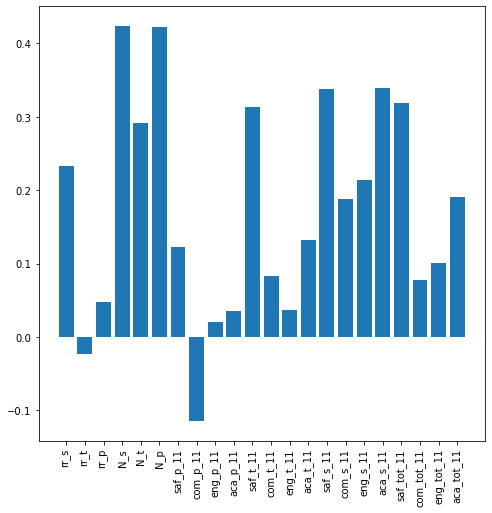

In [60]:
plt.figure(figsize = (8,8))
plt.bar(correlations[survey_fields].index,correlations[survey_fields])
plt.xticks(rotation = 90)
plt.show()

The variables with correlation above 0.3 are:

* N_s - Number of student respondents
* N_p - Number of parent respondents
* saf_t_11 - Safety and Respect score based on teacher responses
* saf_s_11 - Safety and Respect score based on student responses
* aca_s_11 - Academic expectations score based on student responses
* saf_tot_11 - Communication total score

Most of these columns can be seen as general engagement by the school with the students, but we will particularly look at the safety and respect score based on student response column. 

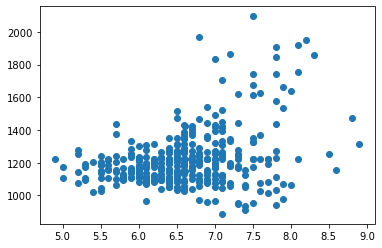

In [33]:
plt.scatter(combined['saf_s_11'], combined['sat_score'])

There seems to be a group of schools with extremely high SAT scores with relatively similar safety scores. They could be from a similar neighborhood.

In [59]:
combined.groupby('boro')['saf_s_11'].agg(['mean','median'])

,mean,median
boro,,
Bronx,6.606577,6.60
Brooklyn,6.370755,6.40
Manhattan,6.831370,6.80
Queens,6.721875,6.75
Staten Island,6.530000,6.55


Manhattan and Queens have the highest safety scores. Brooklyn is the lowest.

### Racial Differences in SAT scores

<AxesSubplot:>

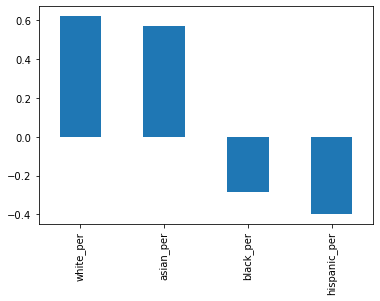

In [62]:
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()['sat_score'][race_cols].plot.bar()


We see that a higher percentage of white or asian students correlates positively with sat scores, where a higher percentage of hispanic or black students correlates negatively with sat score. This could be due to funding and relative wealth of the school and students and their families. 

<AxesSubplot:xlabel='hispanic_per', ylabel='sat_score'>

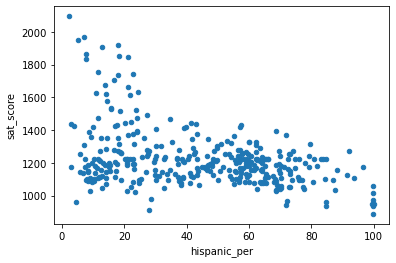

In [63]:
combined.plot.scatter('hispanic_per','sat_score')

In [68]:
print(combined[combined['hispanic_per'] > 95]['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [69]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The above schools are schools which specialize in science and technology and recieve extra funding. These schools only admit students who pass an entrance exam. This can explain their particularly high SAT scores. It does not explain their lack of hispanic students however. Below, we also see that many of these same schools have fewer black students as well.

In [81]:
print(combined[(combined["black_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                  STUYVESANT HIGH SCHOOL
151           BRONX HIGH SCHOOL OF SCIENCE
302            TOWNSEND HARRIS HIGH SCHOOL
356    STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


### Gender differences in SAT scores

<AxesSubplot:>

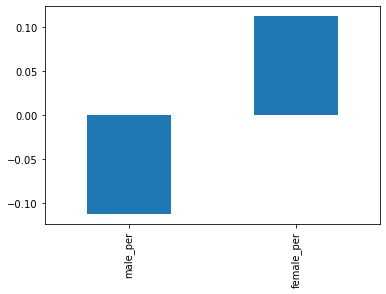

In [73]:
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar()

Female students tend to do better in school and there are plenty of recent studies showing that they perform better in comparison to male students. Neither correlation is particularly strong however we have seen enrollment in colleges for example become skewed towards female students.

<AxesSubplot:xlabel='female_per', ylabel='sat_score'>

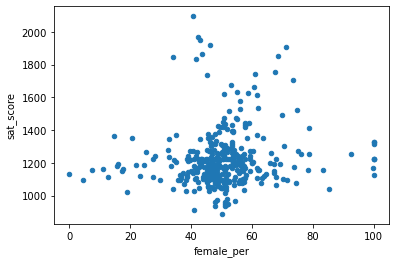

In [77]:
combined.plot.scatter("female_per", "sat_score")

As stated, a slight correlation. There is a group of schools with higher female student populations ~60%+ which do seem to have higher SAT scores. We can take a closer look.

In [78]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools tend to be selective liberal arts colleges.

In [79]:
print(combined[(combined["female_per"] < 50) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
198                           BROOKLYN LATIN SCHOOL, THE
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


We can see some familiar names here with our selective technology and science schools having a disproportionately low number of female students while still having high SAT scores.

# AP Exam Scores vs SAT Scores

<AxesSubplot:xlabel='ap_per', ylabel='sat_score'>

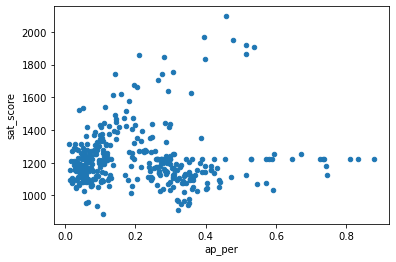

In [82]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

combined.plot.scatter(x='ap_per', y='sat_score')

We can see a correlation above between SAT scores and the proportion of students who take AP exams. This may have to do with expectations of college for students.

# Conclusions

Overall we have identified some possible features for identifying variations SAT scores. The analysis here could lead to an investigation into a variety of different areas for the school system to address and attempt to reduce variation in score.